In [295]:
from IPython.display import display
import numpy as np
# import modin.pandas as pd
import pandas as pd
import datetime
import time
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb


from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import (
    LinearRegression, Ridge, Lasso, RandomizedLasso)
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE, f_regression

import itertools

import warnings
import json

warnings.filterwarnings('ignore')

plt.style.use("fivethirtyeight")
sns.set_style({'font.sans-serif': ['simsun', 'Arial']})
sns.set_style('darkgrid', {'font.sans-serif': ['simhei', 'Arial']})
%matplotlib inline

# np.random.seed(4590)
data_path = r'./train_data.csv'
df = pd.read_csv(data_path)
df.head(5)

,企业编号,企业总评分,软著数量,作品著作数量,项目数量,纳税A级年份_2014,纳税A级年份_2015,纳税A级年份_2016,纳税A级年份_2017,纳税A级年份增长1,...,应收账款周转天数(天)_mean,应收账款周转天数(天)_max,应收账款周转天数(天)_min,应收账款周转天数(天)_std,应收账款周转天数(天)滚动增长_mean,存货周转天数(天)_mean,存货周转天数(天)_max,存货周转天数(天)_min,存货周转天数(天)_std,存货周转天数(天)滚动增长_mean
0,1001,75.374276,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,...,107.589270,191.707773,63.791689,44.495607,0.151392,414.778035,1089.655763,176.283983,325.371499,1.562757
1,1002,79.830122,2.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,...,46.903333,56.590000,39.830000,6.234116,0.023916,6.506667,7.040000,5.010000,0.702335,0.045330
2,1003,78.318264,2.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,84.275556,139.910000,56.020000,33.143654,-0.040224,54.918889,75.540000,38.010000,11.089465,0.031792
3,1004,83.253376,0.0,6.0,1.0,0.0,0.0,2.0,1.0,0.0,...,26.720000,35.360000,17.290000,6.024438,0.081857,6.954444,7.900000,6.240000,0.618448,0.021711
4,1005,83.291493,6.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,94.050000,110.260000,77.850000,9.652235,0.012921,108.584444,357.190000,44.160000,101.728838,0.344086


In [296]:
y = df[['企业编号', '企业总评分']]
x = df.drop(['企业总评分'], axis=1)

xtrain, xtest, ytrain, ytest = train_test_split(
    x, y, test_size=0.2, random_state=31)
ytrain_id = ytrain['企业编号']
ytrain = ytrain['企业总评分']
ytest_id = ytest['企业编号']
ytest = ytest['企业总评分']
print(xtrain.shape, xtest.shape, ytrain.shape, ytest.shape)

id_train = xtrain['企业编号']
id_test = xtest['企业编号']
xtrain.drop(['企业编号'], axis=1, inplace=True)
xtest.drop(['企业编号'], axis=1, inplace=True)
feature_name=xtrain.columns.values

(2364, 335) (592, 335) (2364,) (592,)


# Scalling

In [0]:
sc_X = StandardScaler()
xtrain_sc = sc_X.fit_transform(xtrain)
xtest_sc = sc_X.transform(xtest)
xtrain_sc=pd.DataFrame(xtrain_sc)
xtest_sc=pd.DataFrame(xtest_sc)



# LGBM

In [0]:
nfolds = 10
folds = KFold(n_splits=nfolds, shuffle=True, random_state=15)

In [0]:
params = {
    # objective and metric
    "objective": "regression",
    "metric": 'rmse',
    "boosting": "gbdt",

    # for the Leaf-wise (Best-first) Tree
    "num_leaves": 120, 
    # smaller than 2^(max_depth), This is the main parameter to control the complexity of the tree model. With larger can get higher accuracy 
    "min_data_in_leaf": 10, # Setting it to a large value can avoid growing too deep a tree, but may cause under-fitting.
    "max_depth": 7, # limit the tree depth explicitly.

    # For Faster Speed
    "bagging_fraction": 0.7,
    "bagging_freq": 1,
#     "max_bin": 5, # more small more faster
    "bagging_seed": 11,

    # For Better Accuracy
    "max_bin": 40, # lager but slower
    "learning_rate": 0.005,

    # deal with over fitting
      # Use small max_bin
      # Use small num_leaves
      # Use min_data_in_leaf and min_sum_hessian_in_leaf
      # Use bagging by set bagging_fraction and bagging_freq
      # Use feature sub-sampling by set feature_fraction
      # Use bigger training data
      # Try lambda_l1, lambda_l2 and min_gain_to_split for regularization
      # Try max_depth to avoid growing deep tree
    "feature_fraction": 0.8,
    "lambda_l1": 0.5,

    "min_child_samples": 100,

    # other
    "n_estimators": 1500,
    "verbosity": -1,
    "n_jobs":-1,
}


In [0]:
def train_lgbm(xtrain, ytrain, xtest, ytest, params):
    feature_importance_df = np.zeros((xtrain.shape[1], nfolds))
    mvalid = np.zeros(len(xtrain))
    mfull = np.zeros(len(xtest))
    models = []


    for fold_, (trn_idx, val_idx) in enumerate(folds.split(xtrain.values, ytrain.values)):
        print('----')
        print("fold n°{}".format(fold_))

        x0, y0 = xtrain.iloc[trn_idx], ytrain.iloc[trn_idx]
        x1, y1 = xtrain.iloc[val_idx], ytrain.iloc[val_idx]

        trn_data = lgb.Dataset(x0, label=y0)
        val_data = lgb.Dataset(x1, label=y1)

        num_round = 10000
        clf = lgb.train(params,
                        trn_data,
                        num_round,
                        valid_sets=[trn_data, val_data],
                        verbose_eval=500,
                        early_stopping_rounds=150)

        mvalid[val_idx] = clf.predict(x1, num_iteration=clf.best_iteration)

        feature_importance_df[:, fold_] = clf.feature_importance()

        mfull += clf.predict(xtest,
                             num_iteration=clf.best_iteration) / folds.n_splits
        
        models.append(clf)


    test_error=np.sqrt(mean_squared_error(mfull.astype(int), ytest.astype(int)))
    print()
    print('rmse:', test_error)
    return models, test_error, feature_importance_df

In [231]:
models, test_error, feature_importance_df=train_lgbm(xtrain_sc, ytrain, xtest_sc, ytest, params)

----
fold n°0
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 1.91007	valid_1's rmse: 3.53625
[1000]	training's rmse: 1.26945	valid_1's rmse: 3.4966
[1500]	training's rmse: 0.883574	valid_1's rmse: 3.48136
Did not meet early stopping. Best iteration is:
[1500]	training's rmse: 0.883574	valid_1's rmse: 3.48136
----
fold n°1
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 1.96706	valid_1's rmse: 2.93421
[1000]	training's rmse: 1.29948	valid_1's rmse: 2.89127
Early stopping, best iteration is:
[878]	training's rmse: 1.42524	valid_1's rmse: 2.88894
----
fold n°2
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 1.95947	valid_1's rmse: 3.27187
[1000]	training's rmse: 1.30038	valid_1's rmse: 3.22855
Early stopping, best iteration is:
[1007]	training's rmse: 1.29375	valid_1's rmse: 3.22767
----
fold n°3
Training until validation scores don't improve for 150 rounds.
[500]	training's 

# NN

In [0]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

In [0]:
# ytrain_sc = (ytrain/100).values.reshape(-1, 1)
# ytest_sc = (ytest/100).values.reshape(-1, 1)

ytrain_sc = (ytrain).values.reshape(-1, 1)
ytest_sc = (ytest).values.reshape(-1, 1)

In [0]:
xtrain_th=torch.from_numpy(xtrain_sc.values).float()
xtest_th=torch.from_numpy(xtest_sc.values).float()


ytrain_th=torch.from_numpy(ytrain_sc).float()
ytest_th=torch.from_numpy(ytest_sc).float()

In [0]:
xtrain_th, ytrain_th = Variable(xtrain_th), Variable(ytrain_th)
xtest_th, ytest_th = Variable(xtest_th), Variable(ytest_th)

In [0]:
net = torch.nn.Sequential(
        torch.nn.Linear(xtrain_th.shape[1], 200),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(200, 500),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(500, 300),
        torch.nn.LeakyReLU(),
#         torch.nn.Linear(300, 100),
#         torch.nn.LeakyReLU(),
#         torch.nn.Linear(100, 50),
#         torch.nn.LeakyReLU(),
        torch.nn.Linear(300, ytrain_th.shape[1]),
    )

In [0]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.05)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss
train_loss=[]


In [0]:

for t in range(2000):
    prediction = net(xtrain_th)     # input x and predict based on x

    loss = loss_func(prediction, ytrain_th)     # must be (1. nn output, 2. target)
    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()
    train_loss.append(loss.data.numpy())
    
    if t % 100 ==0:
      
      print('Iter:',t,'Loss:',train_loss[-1])
      
      


Iter: 0 Loss: 0.82130826
Iter: 100 Loss: 278.2739
Iter: 200 Loss: 0.3325121
Iter: 300 Loss: 0.23544528
Iter: 400 Loss: 0.37444183
Iter: 500 Loss: 0.9996894
Iter: 600 Loss: 0.6403555
Iter: 700 Loss: 0.16326748
Iter: 800 Loss: 0.12115719
Iter: 900 Loss: 0.1315243
Iter: 1000 Loss: 0.4370408


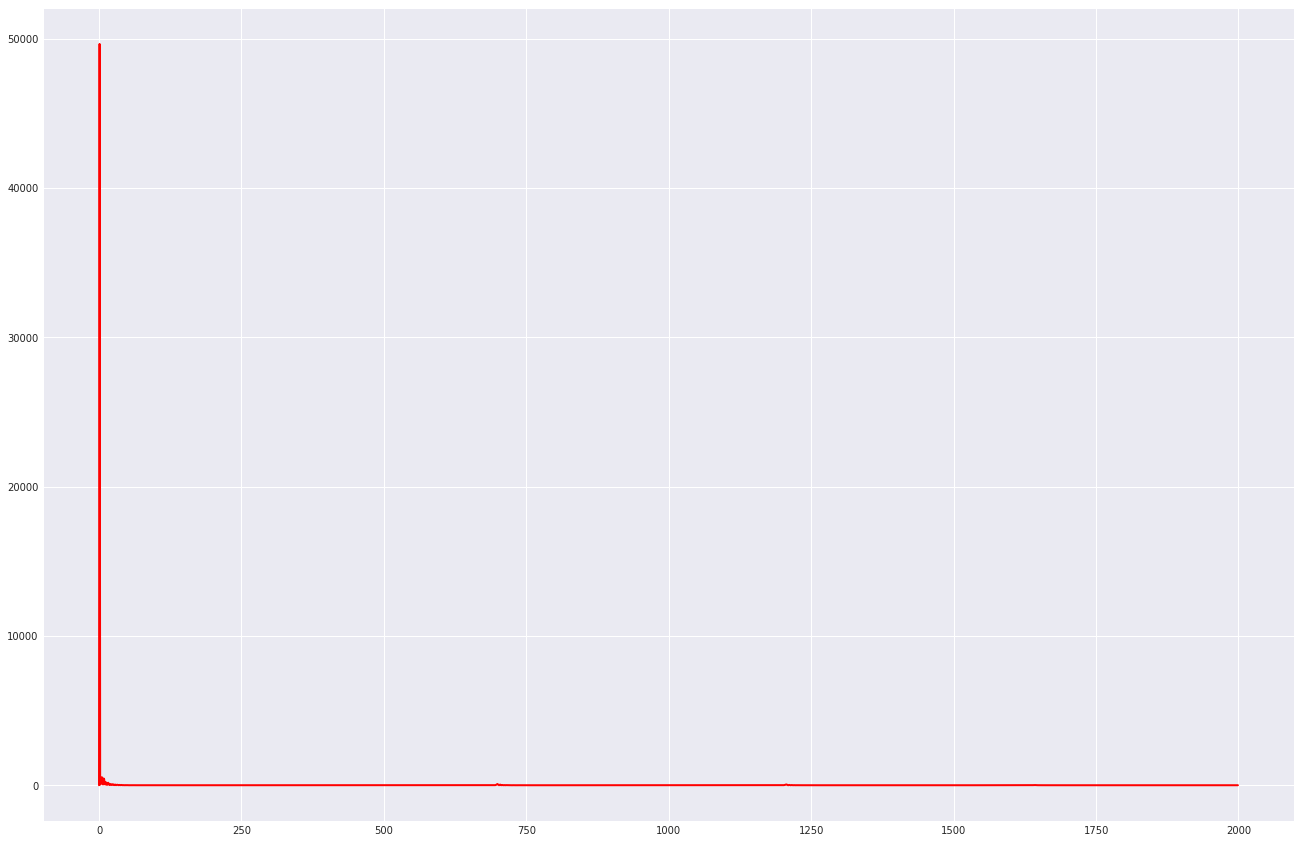

In [304]:
train_loss_=np.array(list(map(lambda x: float(x),train_loss)))


plt.figure(figsize=(20,15))
plt.plot(np.arange(0,2000),train_loss_,color="red",linewidth=2)

In [0]:
net.eval()
test_prediction = net(xtest_th)
mean_squared_error((test_prediction*100).data.numpy().astype(int), ytest.values.astype(int).reshape(-1,1))

# Cross Validation

In [0]:
sc_X = StandardScaler()
xtrain_sc = sc_X.fit_transform(xtrain)
xtest_sc = sc_X.transform(xtest)
xtrain_sc=pd.DataFrame(xtrain_sc)
xtest_sc=pd.DataFrame(xtest_sc)

ytrain_sc = (ytrain/100).values.reshape(-1, 1)
ytest_sc = (ytest/100).values.reshape(-1, 1)

In [0]:
# class LinearRegressionModel(torch.nn.Module):
#     def __init__(self, input_dim, n_hidden_1, n_hidden_2, output_dim):
#         super(LinearRegressionModel, self).__init__()
#         self.layer1 = torch.nn.Sequential(torch.nn.Linear(
#             input_dim, n_hidden_1), torch.nn.LeakyReLU())
#         self.layer2 = torch.nn.Sequential(torch.nn.Linear(
#             n_hidden_1, n_hidden_2), torch.nn.LeakyReLU())
#         self.layer3 = torch.nn.Sequential(
#             torch.nn.Linear(n_hidden_2, output_dim))

#     def forward(self, x):
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         return x

In [0]:
from sklearn.model_selection import KFold
nfolds = 10
folds = KFold(n_splits=nfolds, shuffle=True, random_state=31)

In [0]:
# optimizer = torch.optim.Adam(net.parameters(), lr=0.05)
# loss_func = torch.nn.MSELoss()
# for t in range(2000):
  
# #     prediction = net(xtrain_th)     # input x and predict based on x
#     model=LinearRegressionModel(xtrain_th.shape[1], 200, 500, ytrain_th.shape[1])
    

    
#     loss = loss_func(prediction, ytrain_th)     # must be (1. nn output, 2. target)
#     optimizer.zero_grad()   # clear gradients for next train
#     loss.backward()         # backpropagation, compute gradients
#     optimizer.step()
#     test_prediction = net(xtest_th)
#     test_loss = loss_func(test_prediction, ytest_th)
#     train_loss_list.append(loss.data.numpy())
#     test_loss_list.append(test_loss.data.numpy())
    
#     if t % 100 ==0:
      
#       print('Iter:',t,'Loss:',test_loss.data.numpy())

In [147]:
# feature_importance_df = np.zeros((xtrain.shape[1], nfolds))
# mvalid = np.zeros(len(xtrain))
mfull = np.zeros(len(xtest))
mfull=mfull.reshape(-1,1)

xtest_th=torch.from_numpy(xtest_sc.values).float()
ytest_th=torch.from_numpy(ytest_sc).float()


for fold_, (trn_idx, val_idx) in enumerate(folds.split(xtrain_sc.values, ytrain_sc)):
    print('----')
    print("fold n°{}".format(fold_))

    x0, y0 = xtrain_sc.iloc[trn_idx], ytrain_sc[trn_idx]
    x1, y1 = xtrain_sc.iloc[val_idx], ytrain_sc[val_idx]
    
    x0=torch.from_numpy(x0.values).float()
    y0=torch.from_numpy(y0).float()
    
    x0, y0 = Variable(x0), Variable(y0)
    
    
    x1=torch.from_numpy(x1.values).float()
    y1=torch.from_numpy(y1).float()
    
    x1, y1 = Variable(x1), Variable(y1)
    
    


    for t in range(5000):
        net.train()
        prediction = net(xtrain_th)     # input x and predict based on x

        loss = loss_func(prediction, ytrain_th)     # must be (1. nn output, 2. target)
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()
        net.eval()
        val_prediction = net(x1)
        val_loss = loss_func(val_prediction, y1)

        if t % 100 ==0:
          print('Iter:',t,'Loss:',val_loss.data.numpy())
        mfull += net(xtest_th).data.numpy()
  
  
  
  
  
#     xtest_th, ytest_th = Variable(xtest_th), Variable(ytest_th)

#     num_round = 10000
#     clf = lgb.train(params,
#                     trn_data,
#                     num_round,
#                     valid_sets=[trn_data, val_data],
#                     verbose_eval=500,
#                     early_stopping_rounds=150)
    
#     mvalid[val_idx] = clf.predict(x1, num_iteration=clf.best_iteration)

#     feature_importance_df[:, fold_] = clf.feature_importance()

#     mfull += clf.predict(xtest,
#                          num_iteration=clf.best_iteration) / folds.n_splits
    
    


----
fold n°0
Iter: 0 Loss: 0.00027148222
Iter: 100 Loss: 0.030643798
Iter: 200 Loss: 0.033978548
Iter: 300 Loss: 0.0001771865
Iter: 400 Loss: 0.00085099746
Iter: 500 Loss: 0.00014126788
Iter: 600 Loss: 0.00011504882
Iter: 700 Loss: 0.004909785
Iter: 800 Loss: 0.00052021974
Iter: 900 Loss: 0.002186279
Iter: 1000 Loss: 0.0030265327
Iter: 1100 Loss: 0.00011693134
Iter: 1200 Loss: 0.0025361583
Iter: 1300 Loss: 0.07036637
Iter: 1400 Loss: 0.0001158658
Iter: 1500 Loss: 7.646118e-05
Iter: 1600 Loss: 0.009056995
Iter: 1700 Loss: 0.027844355
Iter: 1800 Loss: 4.0123585e-05
Iter: 1900 Loss: 0.0031053936
Iter: 2000 Loss: 0.00041154234
Iter: 2100 Loss: 55689.16
Iter: 2200 Loss: 195.76784
Iter: 2300 Loss: 81.35335
Iter: 2400 Loss: 50.7167
Iter: 2500 Loss: 35.497787
Iter: 2600 Loss: 26.439558
Iter: 2700 Loss: 20.619282
Iter: 2800 Loss: 19.522799
Iter: 2900 Loss: 14.434976
Iter: 3000 Loss: 11.97477
Iter: 3100 Loss: 10.075365
Iter: 3200 Loss: 450.9162
Iter: 3300 Loss: 8.8599825
Iter: 3400 Loss: 7.4783

KeyboardInterrupt: ignored

In [0]:
np.sqrt(mean_squared_error(mfull.astype(int)*100, ytest.astype(int)))

# PCA

In [0]:
from sklearn.decomposition import PCA
from matplotlib import  pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch

In [0]:
pca = PCA(n_components=3)
pca.fit(x.values)
pca_x=pca.fit_transform(x.values)

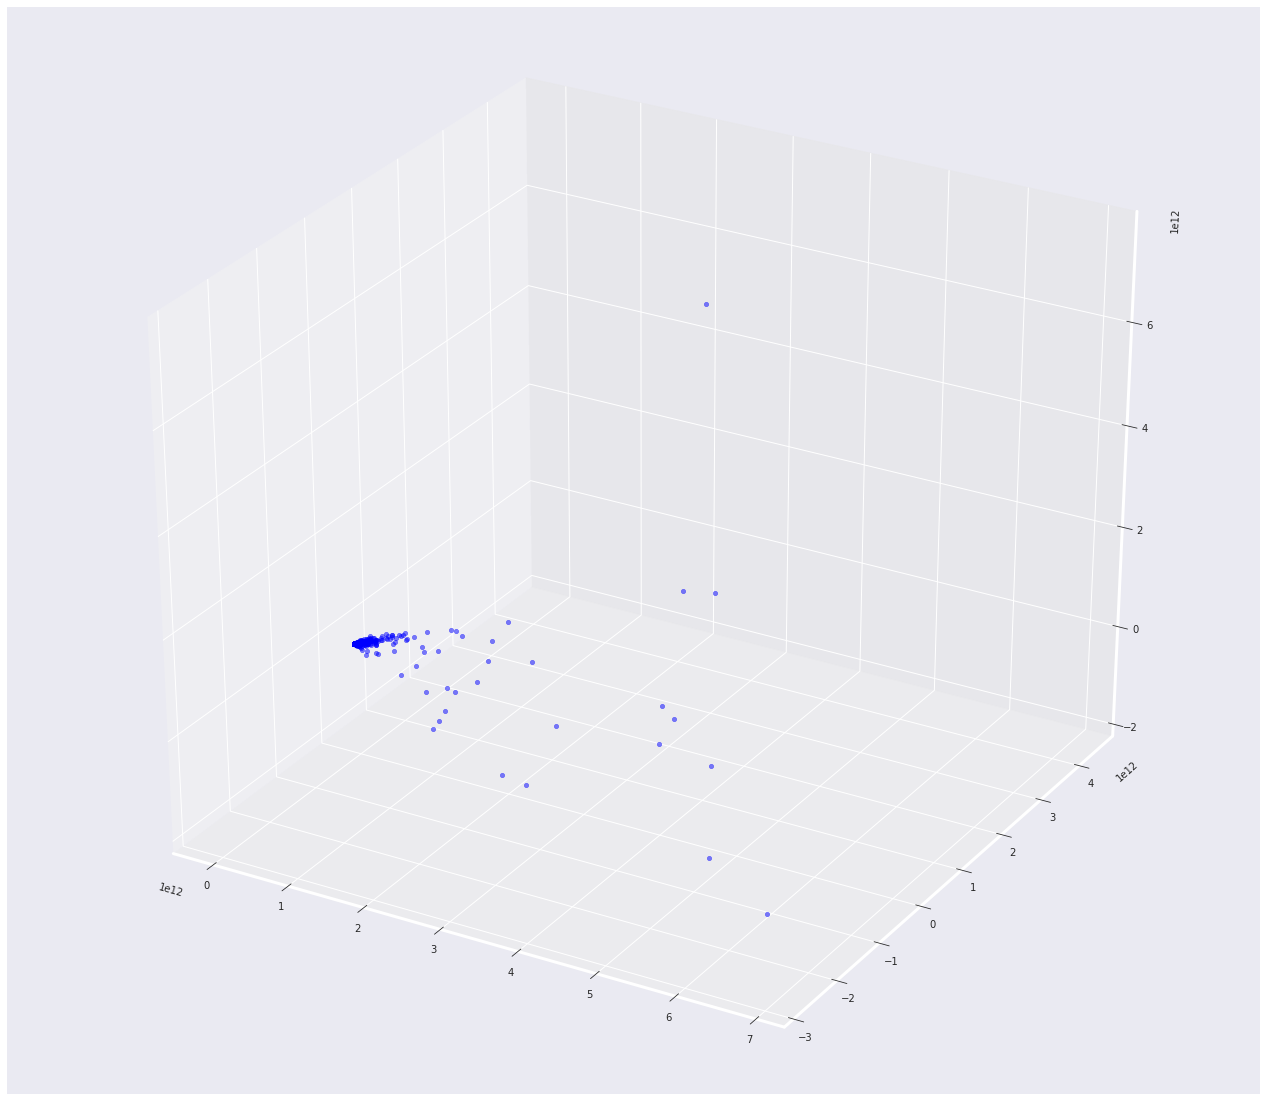

In [259]:


fig = plt.figure(figsize=(20,20)) 
ax = fig.add_subplot(111,projection='3d')

for m in range(pca_x.shape[0]):
    ax.scatter(pca_x[m,0],pca_x[m,1],pca_x[m,2], color='blue', alpha=0.5)
#     ax.text(U[m,0],U[m,1],U[m,2], '%s' % (str(user_index[m])), size=7, zorder=1,color='k')

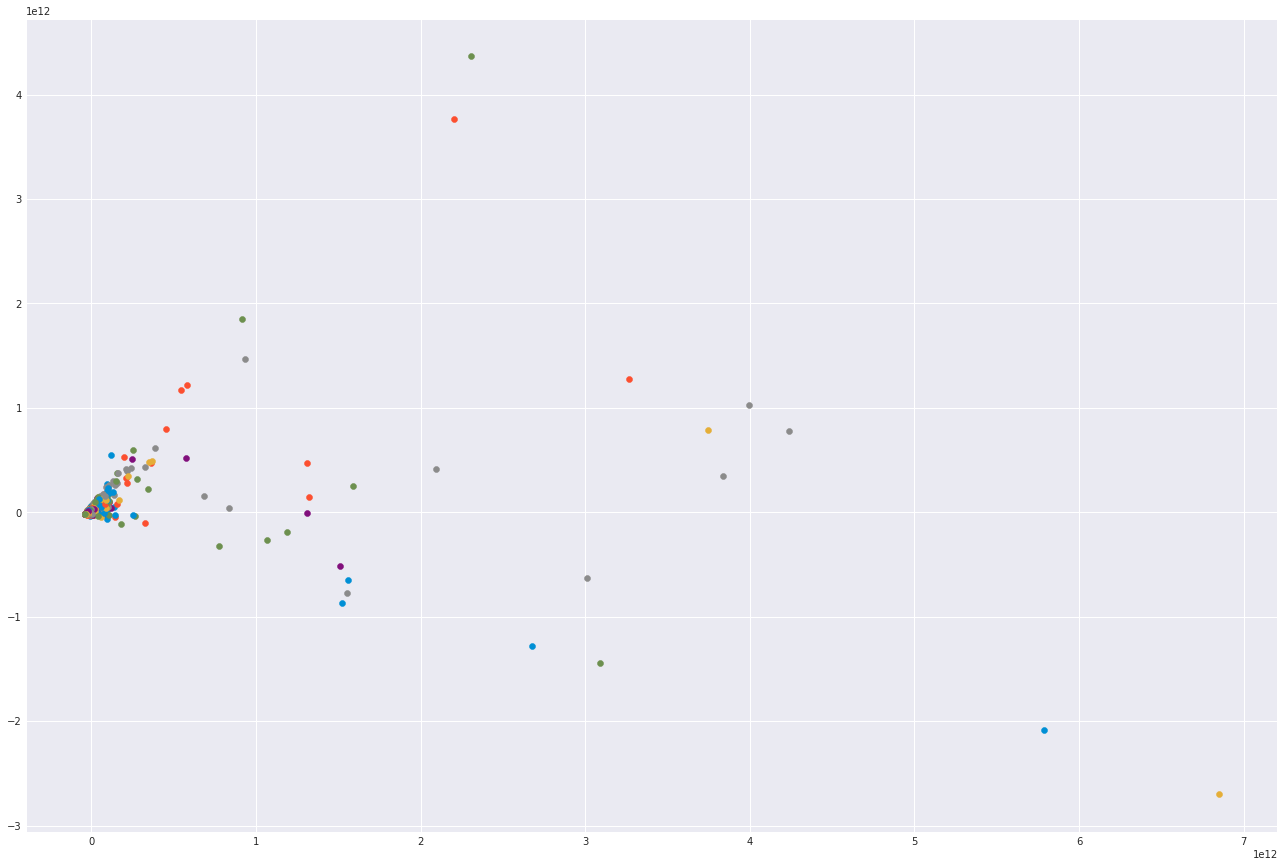

In [260]:
pca = PCA(n_components=2)
pca.fit(x.values)
pca_x=pca.fit_transform(x.values)

plt.figure(figsize=(20,15))
for x_,y_ in pca_x:
  plt.scatter(x_,y_)

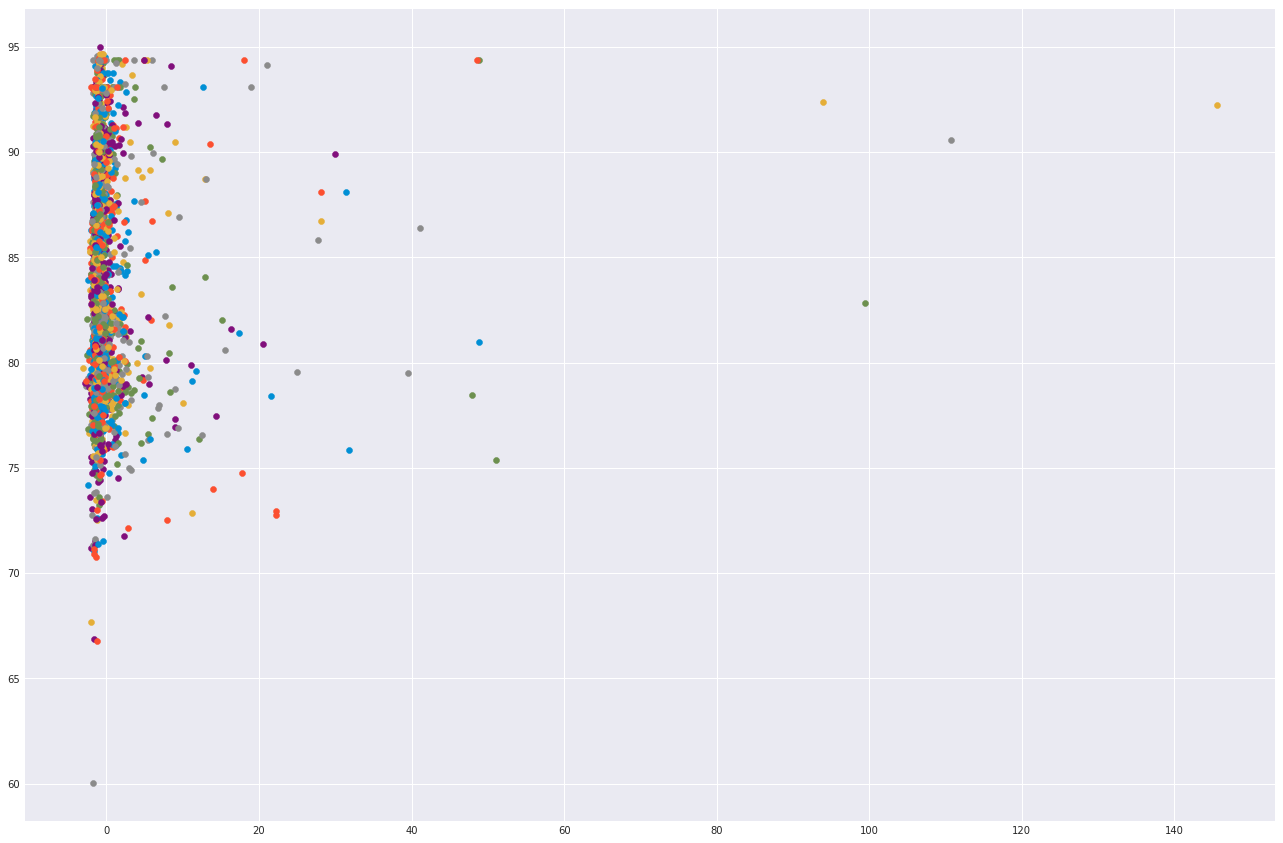

In [270]:
pca = PCA(n_components=1)
pca.fit(xtrain_sc.values)
pca_x=pca.fit_transform(xtrain_sc.values)

plt.figure(figsize=(20,15))
for x_,y_ in zip(pca_x,ytrain.values):
    plt.scatter(x_[0],y_)
#     print(x_[0],y_)
#     break

In [0]:
pca = PCA(n_components=2)
pca.fit(xtrain_sc.values)
pca_x=pca.fit_transform(xtrain_sc.values)




# for m in range(pca_x.shape[0]):
#     ax.scatter(x=pca_x[m,0],y=pca_x[m,1],z=pca_x[m,2], color='blue', alpha=0.5)
#     ax.text(U[m,0],U[m,1],U[m,2], '%s' % (str(user_index[m])), size=7, zorder=1,color='k')


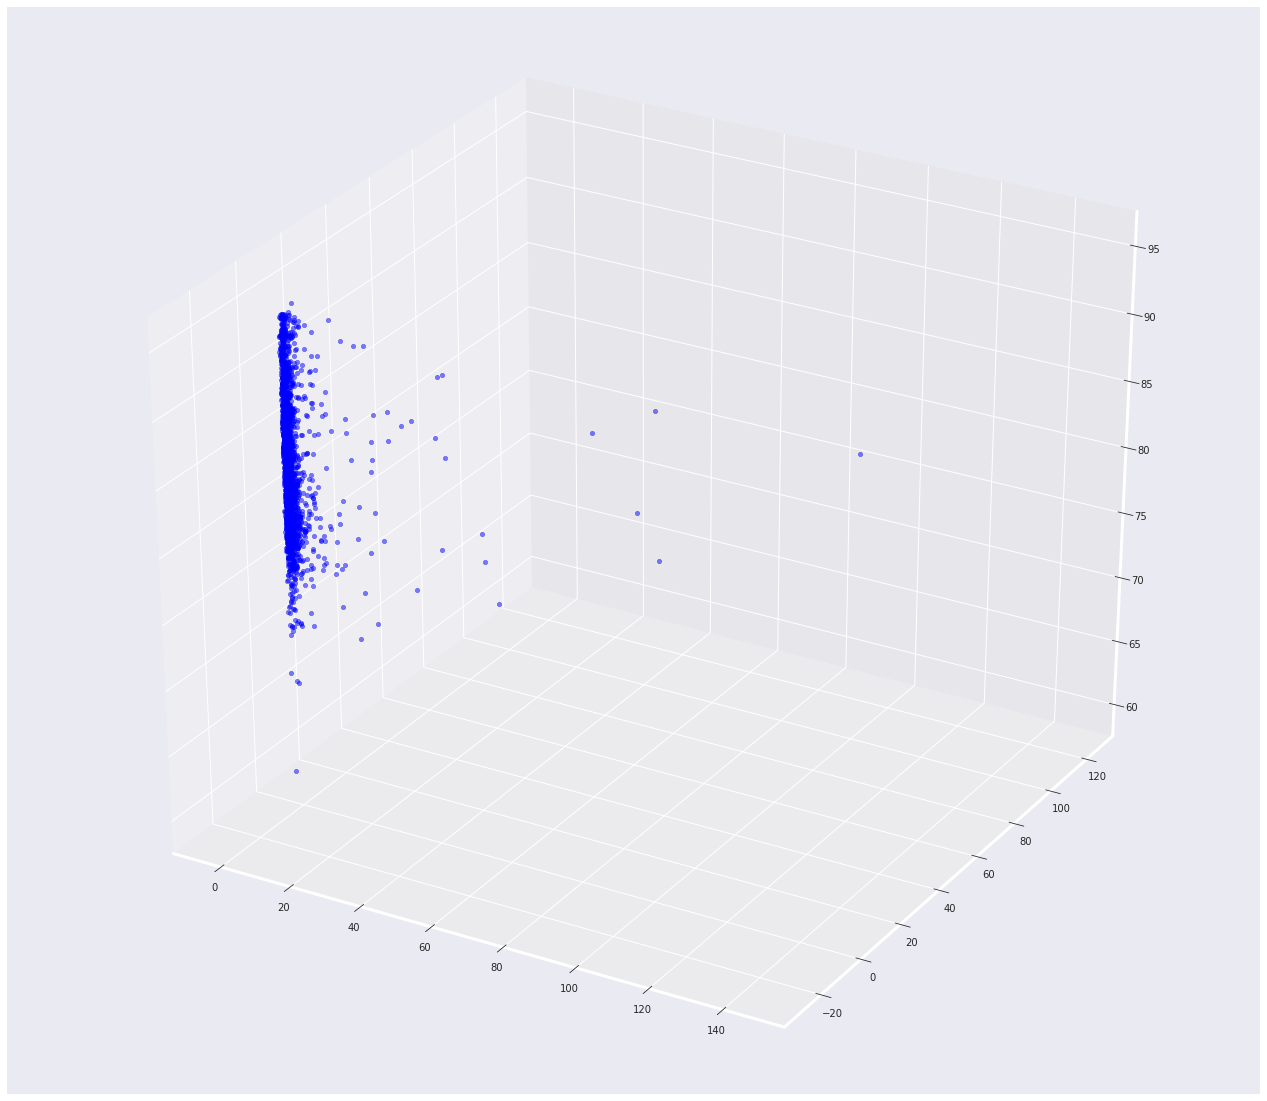

In [277]:
fig = plt.figure(figsize=(20,20)) 
ax = fig.add_subplot(111,projection='3d')

for x_,y_ in zip(pca_x,ytrain.values):
  ax.scatter(x_[0],x_[1],y_, color='blue', alpha=0.5)